In [2]:
import pandas as pd
from sqlalchemy import create_engine

In [3]:
df = pd.read_csv("mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv")

In [4]:

print(df.columns)

Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'startdate', 'enddate',
       'drug_type', 'drug', 'drug_name_poe', 'drug_name_generic',
       'formulary_drug_cd', 'gsn', 'ndc', 'prod_strength', 'dose_val_rx',
       'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'route'],
      dtype='object')


In [5]:
import pandas as pd
import numpy as np

# Handle missing values
df.dropna(subset=['drug'], inplace=True)

# Clean text data (example: lowercasing)
df['drug'] = df['drug'].str.lower()

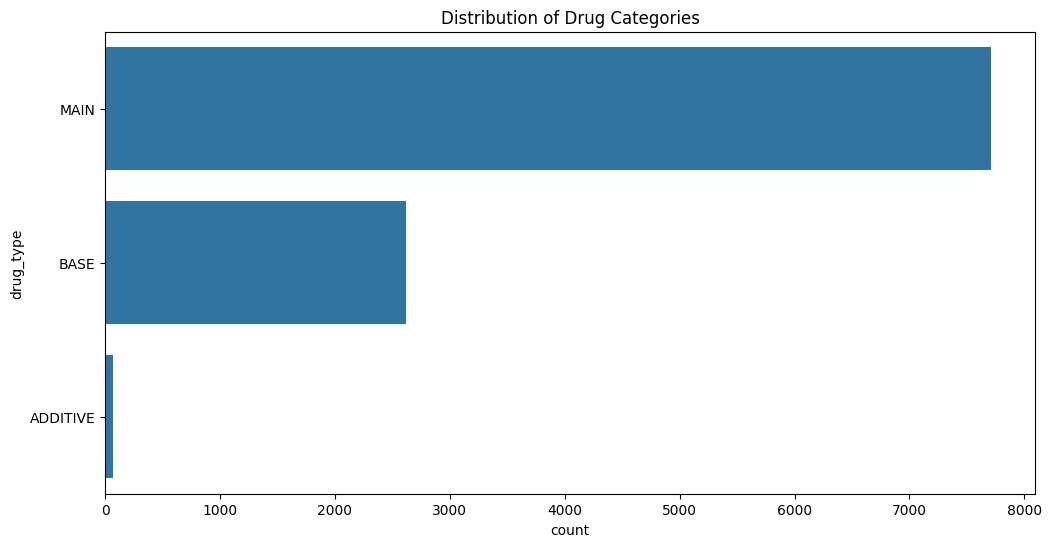

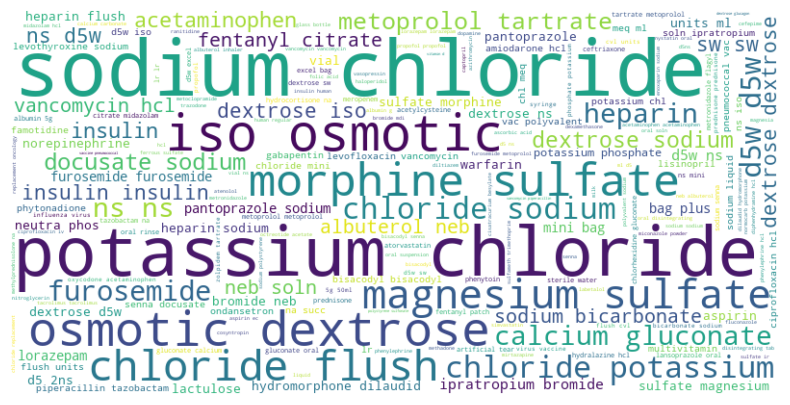

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Plot the distribution of drug categories
plt.figure(figsize=(12, 6))
sns.countplot(y='drug_type', data=df, order=df['drug_type'].value_counts().index)
plt.title('Distribution of Drug Categories')
plt.show()

# Generate a word cloud of the drug descriptions
text = ' '.join(df['drug'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [8]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and generate embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

df['embeddings'] = df['drug'].apply(lambda x: get_bert_embeddings(x))


C:\Users\supre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\supre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\supre\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data for training
X = np.vstack(df['embeddings'])
y = df['drug_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    ADDITIVE       0.50      0.07      0.12        15
        BASE       1.00      1.00      1.00       523
        MAIN       0.99      1.00      0.99      1542

    accuracy                           0.99      2080
   macro avg       0.83      0.69      0.70      2080
weighted avg       0.99      0.99      0.99      2080



In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.9923076923076923
F1 Score: 0.9895674902739483
Precision: 0.9892475776151868
Recall: 0.9923076923076923


In [65]:
import pickle

# Train your model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Save the model to a file
pickle.dump(clf, open('drugcat.pkl','wb'))

In [66]:
import pickle

# Load the model from the file
with open('drugcat.pkl', 'rb') as file:
    clf = pickle.load(file)

# Now you can use clf to make predictions
predictions = clf.predict(X_test)